# Machine Learning Exercise 8 - Anomaly Detection & Recommender Systems

This notebook provides solutions for the eighth machine learning assignment from Coursera, focusing on anomaly detection and building recommender systems. For comprehensive details and formulas, see the exercise text.

Here, we implement an anomaly detection algorithm with a Gaussian model on synthetic data and develop a recommender system using collaborative filtering. The dataset for the recommender system involves anime ratings.

## Anomaly detection

In this section of the notebook, we will implement an anomaly detection algorithm using a Gaussian model on synthetic data. After that, we will create a recommendation system by applying the collaborative filtering method and focus on analyzing the anime evaluation dataset.

In [2587]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat
%matplotlib inline

In [2588]:
# Generating a synthetic dataset
np.random.seed(42) # For reproducibility of results
num_normal = 200 # Number of normal points
num_anomalies = 20 # Number of anomalies

# Generate regular data
normal_data = np.random.normal(0, 1, (num_normal, 2))

# Generating anomalous data
anomalies = np.random.normal(5, 1, (num_anomalies, 2))

# Combining normal data and anomalies
X = np.vstack((normal_data, anomalies))



In [2589]:
# Generating a validation dataset
num_val_normal = 100
num_val_anomalies = 10

val_normal_data = np.random.normal(0, 1, (num_val_normal, 2))
val_anomalies = np.random.normal(5, 1, (num_val_anomalies, 2))
Xval = np.vstack((val_normal_data, val_anomalies))

# Create labels for the validation dataset
yval = np.zeros(Xval.shape[0])
yval[num_val_normal:] = 1 # Mark anomalous points as 1


In [2590]:
# data = loadmat('data/ex8data1.mat')
# X = data['X']
X.shape

(220, 2)

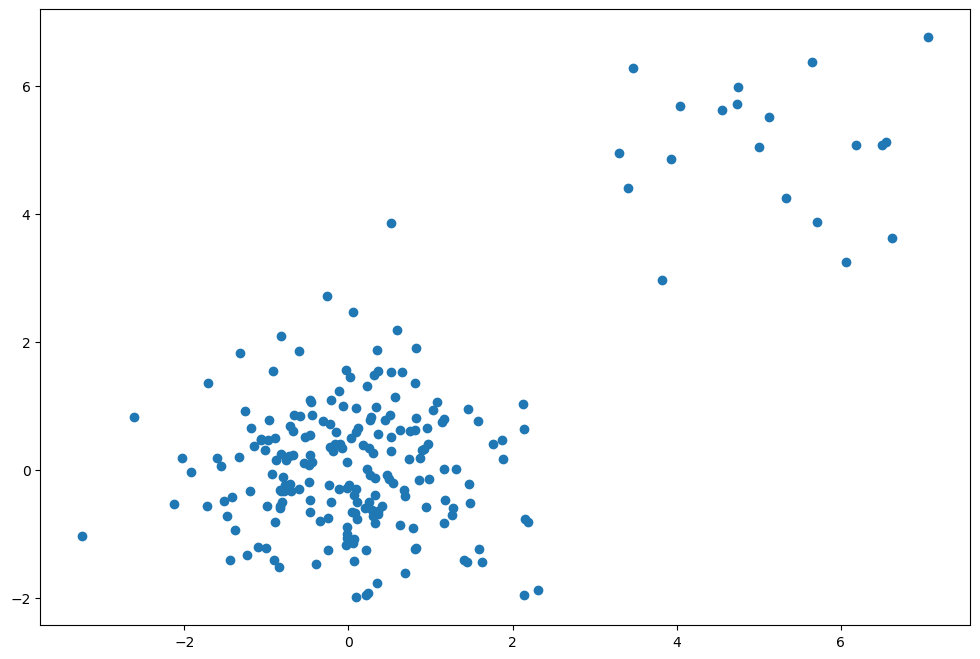

In [2591]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,0], X[:,1])

It appears that there's a pretty tight cluster in the center with several values further out away from the cluser.  In this simple example, these could be considered anomalies.  To find out, we're tasking with estimating a gaussian distribution for each feature in the data.  To do this we'll create a function that returns the mean and variance for each feature.

In [2592]:
def estimate_gaussian(X):
    mu = X.mean(axis=0)
    sigma = X.var(axis=0)
    
    return mu, sigma

In [2593]:
mu, sigma = estimate_gaussian(X)
mu, sigma

(array([0.46839874, 0.49145848]), array([3.08553887, 2.98503901]))

Now that we have our model parameters, we need to determine a probability threshold which indicates that an example should be considered an anomaly.  To do this, we need to use a set of labeled validation data (where the true anomalies have been marked as such) and test the model's performance at identifying those anaomalies given different threshold values.

In [2594]:


Xval.shape, yval.shape

((110, 2), (110,))

We also need a way to calculate the probability that a data point belongs to a normal distribution.  Fortunately SciPy has this built-in.

In [2595]:
from scipy import stats
dist = stats.norm(mu[0], sigma[0])
dist.pdf(15)

1.9734038515276707e-06

We can also pass in an array to the probability density function and get the probability density at every point in the data set.

In [2596]:
dist.pdf(X[:,0])[0:50]

array([0.12928876, 0.12907611, 0.12598573, 0.12118134, 0.12345729,
       0.12353074, 0.12894651, 0.10042845, 0.11522236, 0.11704905,
       0.12271455, 0.12820761, 0.12251352, 0.11265901, 0.12176229,
       0.12174769, 0.12772692, 0.12844537, 0.12883763, 0.10913409,
       0.12879989, 0.12699859, 0.10595569, 0.12356429, 0.12918852,
       0.12915286, 0.12068689, 0.12716271, 0.11818983, 0.12916656,
       0.12333877, 0.11350616, 0.12849257, 0.12732629, 0.12921683,
       0.12921648, 0.1275793 , 0.07835469, 0.12831046, 0.12833454,
       0.12611904, 0.12255628, 0.11868374, 0.12794452, 0.12270286,
       0.12836134, 0.12031858, 0.1243627 , 0.12909282, 0.12784497])

Let's compute and save the probability density of each of the values in our data set given the gaussian model parameters we calculated above.

In [2597]:
p = np.zeros((X.shape[0], X.shape[1]))
p[:,0] = stats.norm(mu[0], sigma[0]).pdf(X[:,0])
p[:,1] = stats.norm(mu[1], sigma[1]).pdf(X[:,1])

p.shape

(220, 2)

We also need to do this for the validation set (using the same model parameters).  We'll use these probabilities combined with the true label to determine the optimal probability threshold to assign data points as anomalies.

In [2598]:
pval = np.zeros((Xval.shape[0], Xval.shape[1]))
pval[:,0] = stats.norm(mu[0], sigma[0]).pdf(Xval[:,0])
pval[:,1] = stats.norm(mu[1], sigma[1]).pdf(Xval[:,1])

pval.shape

(110, 2)

Next, we need a function that finds the best threshold value given the probability density values and true labels.  To do this we'll calculate the F1 score for varying values of epsilon.  F1 is a function of the number of true positives, false positives, and false negatives.  The equations are in the exercise text.

In [2599]:
def select_threshold(pval, yval):
    best_epsilon = 0
    best_f1 = 0
    f1 = 0
    
    step = (pval.max() - pval.min()) / 1000
    
    for epsilon in np.arange(pval.min(), pval.max(), step):
        preds = pval < epsilon
        
        tp = np.sum(np.logical_and(preds == 1, yval == 1)).astype(float)
        fp = np.sum(np.logical_and(preds == 1, yval == 0)).astype(float)
        fn = np.sum(np.logical_and(preds == 0, yval == 1)).astype(float)
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = (2 * precision * recall) / (precision + recall)
        
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
    
    return best_epsilon, best_f1

In [2600]:
# Averaging the probabilities for each example
pval = pval.mean(axis=1)

# Now pval is a one-dimensional array and can be used in the select_threshold function
epsilon, f1 = select_threshold(pval, yval)


C:\Users\L\AppData\Local\Temp\ipykernel_14196\2592719272.py:15: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


In [2601]:
epsilon, f1 = select_threshold(pval, yval)
epsilon, f1

C:\Users\L\AppData\Local\Temp\ipykernel_14196\2592719272.py:15: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


(0.07613542754266156, 1.0)

Finally, we can apply the threshold to the data set and visualize the results.

In [2602]:
# indexes of the values considered to be outliers
outliers = np.where(p < epsilon)
outliers

(array([104, 131, 200, 201, 201, 202, 202, 203, 203, 204, 204, 205, 205,
        206, 207, 207, 208, 208, 209, 209, 210, 210, 211, 211, 212, 212,
        213, 213, 214, 215, 216, 216, 217, 217, 218, 219], dtype=int64),
 array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1], dtype=int64))

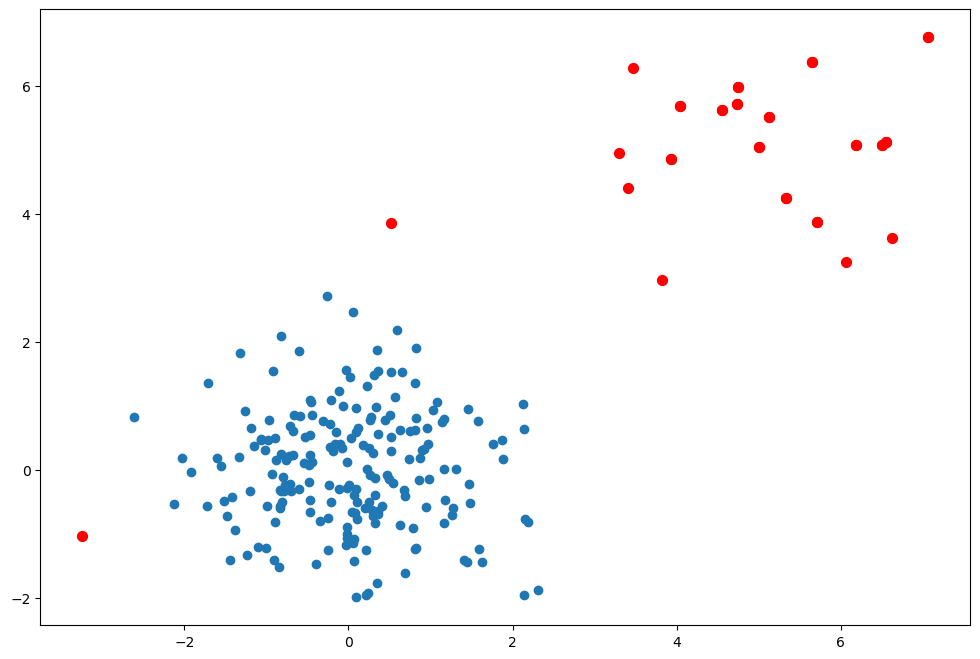

In [2603]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,0], X[:,1])
ax.scatter(X[outliers[0],0], X[outliers[0],1], s=50, color='r', marker='o')

The points in red are the ones that were flagged as outliers.  These seem pretty reasonable.  The top right point that has some separation (but was not flagged) may be an outlier too, but it's fairly close.  There's another example in the text of applying this to a higher-dimensional data set, but there's nothing new to do or look at so we'll move on to the last section.

## Collaborative filtering

Recommendation engines use item and user-based similarity measures to examine a user's historical preferences to make recommendations for new "things" the user might be interested in.  In this exercise we'll implement a particular recommendation system algorithm called collaborative filtering and apply it to a data set of anime ratings.

Let's first load and examine the data we'll be working with.

In [2604]:
# size = 10000
# input_file1 = 'Rating.csv'
# input_file2 = 'Anime.csv'
# output_file1 = 'smallRating.csv'
# output_file2 = 'smallAnime.csv'

# # Обработка первого файла
# with open(input_file1, 'r', encoding='utf-8') as file:
#     lines = [next(file) for _ in range(size)]

# with open(output_file1, 'w', encoding='utf-8') as file:
#     file.writelines(lines)

# # Обработка второго файла
# with open(input_file2, 'r', encoding='utf-8') as file:
#     lines = [next(file) for _ in range(size)]

# with open(output_file2, 'w', encoding='utf-8') as file:
#     file.writelines(lines)



In [2605]:
import pandas as pd

# Dataset load
anime_df = pd.read_csv('smallAnime.csv')
ratings_df = pd.read_csv('smallRating.csv')



In [2606]:
ratings_df = ratings_df.drop_duplicates(subset=['anime_id', 'user_id'], keep='last')

# Can now be safely converted to a matrix
pivot_ratings = ratings_df.pivot(index='anime_id', columns='user_id', values='rating').fillna(0)

# Padding with zeros for unrated anime
pivot_ratings = pivot_ratings.fillna(0)

# Convert to NumPy matrix
Y = pivot_ratings.to_numpy()

# Create a matrix of indicators (1 if the user rated the anime; 0 otherwise)
R = np.where(Y > 0, 1, 0)

In [2607]:
# Data limit to the first 1973 anime and 117 users
limited_ratings_df = ratings_df[ratings_df['anime_id'] <= 1973]
limited_ratings_df = limited_ratings_df[limited_ratings_df['user_id'] <= 117]

# Create a pivot table with limited data
pivot_ratings = limited_ratings_df.pivot(index='anime_id', columns='user_id', values='rating').fillna(0)

# Convert to NumPy matrices
Y = pivot_ratings.to_numpy()
R = np.where(Y > 0, 1, 0)

In [2608]:
anime_df.groupby('anime_id').count()

,name,genre,type,episodes,rating,members
anime_id,,,,,,
1,1,1,1,1,1,1
5,1,1,1,1,1,1
6,1,1,1,1,1,1
7,1,1,1,1,1,1
8,1,1,1,1,1,1
...,...,...,...,...,...,...
34476,1,1,1,1,1,1
34502,1,1,1,1,0,1
34503,1,1,1,1,1,1


Y is a (number of animes x number of users) array containing ratings from 1 to 5.  R is an "indicator" array containing binary values indicating if a user has rated a anime or not.  Both should have the same shape.

In [2609]:
# Y = data['Y']
# R = data['R']
# Y.shape, R.shape

We can look at the average rating for a anime by averaging over a row in Y for indexes where a rating is present.

In [2610]:
Y[1,np.where(R[1,:]==1)[0]].mean()

9.25

We can also try to "visualize" the data by rendering the matrix as if it were an image.  We can't glean too much from this but it does give us an idea of a relative density of ratings across users and animes.

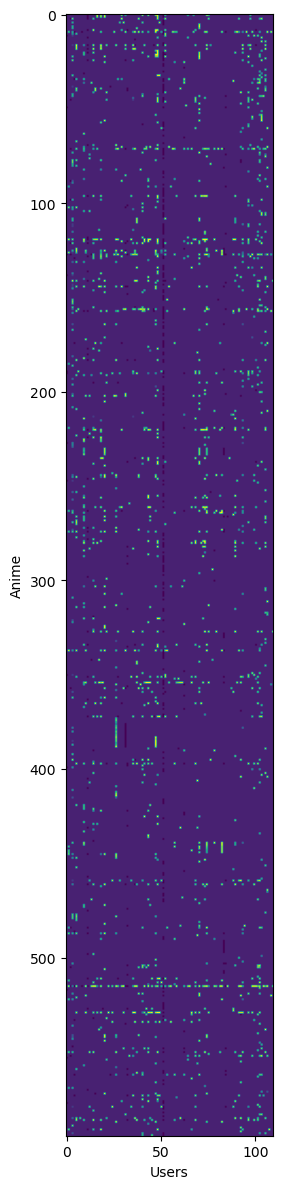

In [2611]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(Y)
ax.set_xlabel('Users')
ax.set_ylabel('Anime')
fig.tight_layout()

Next we're going to implement a cost function for collaborative filtering.  Intuitively, the "cost" is the degree to which a set of anime rating predictions deviate from the true predictions.  The cost equation is given in the exercise text.  It is based on two sets of parameter matrices called X and Theta in the text.  These are "unrolled" into the "params" input so that we can use SciPy's optimization package later on.  Note that I've included the array/matrix shapes in comments (for the data we're using in this exercise) to help illustrate how the matrix interactions work.

In [2612]:
def cost(params, Y, R, num_features):
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_animes = Y.shape[0]
    num_users = Y.shape[1]
    
    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_animes * num_features], (num_animes, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_animes * num_features:], (num_users, num_features)))  # (943, 10)
    
    # initializations
    J = 0
    
    # compute the cost
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    
    return J

In order to test this, we're provided with a set of pre-trained parameters that we can evaluate.  To keep the evaluation time down, we'll look at just a small sub-set of the data.

In [2613]:
from scipy.optimize import minimize

In [2614]:
anime_df = pd.read_csv('smallAnime.csv')
ratings_df = pd.read_csv('smallRating.csv')

In [2615]:
filtered_ratings = ratings_df[ratings_df['rating'] >= 0]
# Вычисление средних оценок для каждого аниме
mean_ratings = filtered_ratings.groupby('anime_id')['rating'].mean()
# Присоединение средних оценок к таблице рейтингов
ratings_with_mean = filtered_ratings.join(mean_ratings, on='anime_id', rsuffix='_mean')

# Нормализация рейтингов путем вычитания средней оценки
ratings_with_mean['normalized_rating'] = ratings_with_mean['rating'] - ratings_with_mean['rating_mean']
pivot_ratings = ratings_with_mean.pivot(index='anime_id', columns='user_id', values='normalized_rating').fillna(0)

In [2616]:
# # Eliminate ratings with negative values
# filtered_ratings = ratings_df[ratings_df['rating'] >= 0]

# # Calculate the average rating for each anime
# mean_ratings = filtered_ratings.groupby('anime_id')['rating'].mean()

# # Attaching average ratings to the rating table
# ratings_with_mean = filtered_ratings.join(mean_ratings, on='anime_id', rsuffix='_mean')

# # Normalize ratings by subtracting the average
# ratings_with_mean['normalized_rating'] = ratings_with_mean['rating'] - ratings_with_mean['rating_mean']
# # Create a pivot table using normalized ratings
# pivot_ratings = ratings_with_mean.pivot(index='anime_id', columns='user_id', values='normalized_rating').fillna(0)

# View results
ratings_with_mean.head()

,user_id,anime_id,rating,rating_mean,normalized_rating
47,1,8074,10,7.031250,2.968750
81,1,11617,10,7.434783,2.565217
83,1,11757,10,8.300000,1.700000
101,1,15451,10,7.857143,2.142857
153,2,11771,10,9.000000,1.000000


In [2617]:
# pivot_ratings = ratings_df.pivot_table(index='anime_id', columns='user_id', values='normalized_rating').fillna(0)
Y = pivot_ratings.to_numpy()
R = np.where(Y > 0, 1, 0)

In [2618]:
# Number of features
# num_features = 3
num_features = 6
# features = 3

# Initialize X and Theta
num_anime, num_users = Y.shape
X = np.random.rand(num_anime, num_features)

Theta = np.random.rand(num_users, num_features)
params = np.concatenate([X.ravel(), Theta.ravel()])

# Finding the optimal learning_rate value
learning_rates = [0.01, 0.1, 1, 10]
best_learning_rate = None
best_cost = float('inf')
X_sub = np.random.rand(5, num_features) # 5 anime, 3 features

Y_sub = Y[:5, :4]
R_sub = R[:5, :4]



Theta_sub = np.random.rand(4, num_features) # 4 users, 3 features
params_sub = np.concatenate([X_sub.ravel(), Theta_sub.ravel()])


cost_value = cost(params_sub, Y_sub, R_sub, num_features)

In [2619]:
X = np.matrix(np.reshape(params[:num_anime * num_features], (num_anime, num_features)))
Theta = np.matrix(np.reshape(params[num_anime * num_features:], (num_users, num_features)))


Great, this matches what the exercise text said we're supposed to get.  Next we need to implement the gradient computations.  Just like we did with the neural networks implementation in exercise 4, we'll extend the cost function to also compute the gradients.

In [2620]:
def cost(params, Y, R, num_features, learning_rate):
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_animes = Y.shape[0]
    num_users = Y.shape[1]
    
    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_animes * num_features], (num_animes, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_animes * num_features:], (num_users, num_features)))  # (943, 10)
    
    # initializations
    J = 0
    X_grad = np.zeros(X.shape)  # (1682, 10)
    Theta_grad = np.zeros(Theta.shape)  # (943, 10)
    
    # compute the cost
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    
    # calculate the gradients
    X_grad = error * Theta
    Theta_grad = error.T * X
    X_grad = (error * Theta) + (learning_rate * X)
    Theta_grad = (error.T * X) + (learning_rate * Theta)

    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(X_grad), np.ravel(Theta_grad)))
    
    return J, grad

In [2621]:
print(X.shape)
print(Theta.shape)


(1973, 6)
(117, 6)


In [2622]:
# Ynorm = Y.copy()
Ynorm = Y - mean_ratings.values.reshape(-1, 1) * R

for anime_id in mean_ratings.index:
    idx = np.where(pivot_ratings.index == anime_id)[0][0]
    Ynorm[idx, R[idx, :] == 1] -= mean_ratings[anime_id]

In [2623]:
# Once you have defined Y and R
num_anime, num_users = Y.shape


# Print values to check
print("Number of anime (num_anime):", num_anime)
print("Number of users (num_users):", num_users)
print("Number of features (num_features):", num_features)

# Next comes the initialization of X and Theta
X = np.random.rand(num_anime, num_features)
Theta = np.random.rand(num_users, num_features)

Number of anime (num_anime): 1973
Number of users (num_users): 117
Number of features (num_features): 6


In [2624]:
params = np.concatenate([X.ravel(), Theta.ravel()])

# Checking params size
print("Params size:", params.shape[0])


Params size: 12540


In [2625]:
best_learning_rate = None
best_cost = float('inf')

for lr in learning_rates:
    params = np.concatenate([X.ravel(), Theta.ravel()])  # Re-initializing parameters
    fmin = minimize(fun=cost, x0=params, args=(Ynorm, R, num_features , lr), 
                    method='CG', jac=True, options={'maxiter': 100})

    
    if fmin.fun < best_cost:
        best_cost = fmin.fun
        best_learning_rate = lr

print("Best learning_rate:", best_learning_rate)


Best learning_rate: 0.01


In [2626]:
J, grad = cost(params_sub, Y_sub, R_sub, num_features, best_learning_rate)


J, grad

(0.0,
 array([5.49534539e-04, 1.76613693e-03, 5.48719606e-03, 4.81067191e-03,
        4.58520184e-04, 7.25242802e-05, 9.88067942e-03, 6.58834700e-03,
        3.65406131e-03, 4.70432248e-03, 2.66550120e-03, 3.44873784e-03,
        6.49044467e-03, 8.82811799e-03, 1.84130023e-03, 8.40361505e-03,
        1.21556630e-03, 2.14992224e-03, 3.71752880e-04, 1.40811862e-03,
        9.17303145e-03, 4.59438747e-03, 7.76658618e-04, 9.59726838e-03,
        8.78992308e-03, 7.54682521e-03, 9.33472792e-03, 2.20129421e-03,
        8.36369293e-03, 6.89991196e-03, 8.69759250e-03, 7.96911566e-03,
        3.46495063e-03, 7.74398537e-03, 2.62456303e-03, 3.28592163e-03,
        1.07905717e-03, 9.35076616e-03, 2.91003363e-03, 5.20622465e-03,
        3.91332836e-03, 9.59928121e-03, 3.35049171e-03, 7.78545821e-03,
        8.55416155e-03, 4.35606497e-03, 3.78171814e-03, 7.47745821e-03,
        9.12895980e-03, 7.54931733e-03, 2.27126366e-03, 8.88307747e-03,
        3.87581667e-03, 5.76229412e-03]))

Our next step is to add regularization to both the cost and gradient calculations.  We'll create one final regularized version of the function (note that this version includes an additional "learning rate" parameter, called "lambda" in the text).

In [2627]:
def cost(params, Y, R, num_features, learning_rate):
    
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_animes = Y.shape[0]
    num_users = Y.shape[1]

    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_animes * num_features], (num_animes, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_animes * num_features:], (num_users, num_features)))  # (943, 10)
    
    # initializations
    J = 0
    X_grad = np.zeros(X.shape)  # (1682, 10)
    Theta_grad = np.zeros(Theta.shape)  # (943, 10)
    
    # compute the cost
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    
    # add the cost regularization
    J = J + ((learning_rate / 2) * np.sum(np.power(Theta, 2)))
    J = J + ((learning_rate / 2) * np.sum(np.power(X, 2)))


    # calculate the gradients with regularization
    X_grad = (error * Theta) + (learning_rate * X)
    Theta_grad = (error.T * X) + (learning_rate * Theta)
    
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(X_grad), np.ravel(Theta_grad)))
    
    return J, grad

In [2628]:

J, grad = cost(params_sub, Y_sub, R_sub, num_features, best_learning_rate)

J, grad

(0.09818488440164494,
 array([5.49534539e-04, 1.76613693e-03, 5.48719606e-03, 4.81067191e-03,
        4.58520184e-04, 7.25242802e-05, 9.88067942e-03, 6.58834700e-03,
        3.65406131e-03, 4.70432248e-03, 2.66550120e-03, 3.44873784e-03,
        6.49044467e-03, 8.82811799e-03, 1.84130023e-03, 8.40361505e-03,
        1.21556630e-03, 2.14992224e-03, 3.71752880e-04, 1.40811862e-03,
        9.17303145e-03, 4.59438747e-03, 7.76658618e-04, 9.59726838e-03,
        8.78992308e-03, 7.54682521e-03, 9.33472792e-03, 2.20129421e-03,
        8.36369293e-03, 6.89991196e-03, 8.69759250e-03, 7.96911566e-03,
        3.46495063e-03, 7.74398537e-03, 2.62456303e-03, 3.28592163e-03,
        1.07905717e-03, 9.35076616e-03, 2.91003363e-03, 5.20622465e-03,
        3.91332836e-03, 9.59928121e-03, 3.35049171e-03, 7.78545821e-03,
        8.55416155e-03, 4.35606497e-03, 3.78171814e-03, 7.47745821e-03,
        9.12895980e-03, 7.54931733e-03, 2.27126366e-03, 8.88307747e-03,
        3.87581667e-03, 5.76229412e-03]))

This result again matches up with the expected output from the exercise code, so it looks like the regularization is working.  Before we train the model, we have one final step.  We're tasked with creating our own anime ratings so we can use the model to generate personalized recommendations.  A file is provided for us that links the anime index to its title.  Let's load the file into a dictionary.

In [2629]:
anime_idx = pd.Series(anime_df.name.values, index=anime_df.anime_id).to_dict()


In [2630]:
# Let's say you want to find an anime title with ID 123
anime_id_to_find = 120

# Getting the name of an anime by its ID
anime_name = anime_idx.get(anime_id_to_find, "Anime not found")
print(anime_name)


Fruits Basket


In [2631]:
anime_idx[1]

'Cowboy Bebop'

We can add our own ratings vector to the existing data set to include in the model.

In [2632]:
pivot_ratings = ratings_df.pivot(index='anime_id', columns='user_id', values='rating').fillna(0)
Y = pivot_ratings.to_numpy()
R = np.where(Y > 0, 1, 0)


In [2633]:
Y.shape, R.shape, ratings.shape

((2402, 123), (2402, 123), (1973, 1))

We're not just about ready to train the collaborative filtering model.  We just need to define some variables and normalize the ratings.

In [2634]:
num_anime, num_users = Y.shape # Initial dimensions

# Initialize X and Theta taking into account the dimensions of Y and R
X = np.random.rand(num_anime, num_features)
Theta = np.random.rand(num_users, num_features)

# Checking dimensions
print("size size:", Y.shape)
print("R size:", R.shape)
print("X size:", X.shape)
print("Theta size:", Theta.shape)


size size: (2402, 123)
R size: (2402, 123)
X size: (2402, 6)
Theta size: (123, 6)


In [2635]:
# Initialization
params = np.concatenate([X.ravel(), Theta.ravel()])

# Check size
print("params size:", params.shape[0]) # Should be 6270

# Split params back into X and Theta
X = np.reshape(params[:num_anime * num_features], (num_anime, num_features))
Theta = np.reshape(params[num_anime * num_features:], (num_users, num_features))

params size: 15150


In [2636]:
print("Y size:", Y.shape)
print("Size R:", R.shape)

# Checking if the Y and R dimensions match the expected dimensions
if Y.shape == (num_anime, num_users) and R.shape == (num_anime, num_users):
     print("Y and R dimensions are correct.")
else:
     print("Y and R dimensions are incorrect.")

# Initialize X and Theta with expected sizes
X = np.random.rand(num_anime, num_features)
Theta = np.random.rand(num_users, num_features)

# Checking X and Theta sizes
print("Size X:", X.shape)
print("Theta size:", Theta.shape)

# Checking if the X and Theta sizes match the expected sizes
if X.shape == (num_anime, num_features) and Theta.shape == (num_users, num_features):
     print("X and Theta dimensions are correct.")
else:
     print("X and Theta dimensions are incorrect.")

Y size: (2402, 123)
Size R: (2402, 123)
Y and R dimensions are correct.
Size X: (2402, 6)
Theta size: (123, 6)
X and Theta dimensions are correct.


In [2637]:
# Trim Y and R to X and Theta sizes
Y_sub = Y[:2402, :123]
R_sub = R[:2402, :123]

# Checking dimensions
print("Y_sub size:", Y_sub.shape)
print("Size R_sub:", R_sub.shape)

Y_sub size: (2402, 123)
Size R_sub: (2402, 123)


In [2638]:
from scipy.optimize import minimize

# Assuming Y_sub and R_sub are truncated matrices
learning_rates = [0.01, 0.1, 1, 10] # list of possible values
for lr in learning_rates:
     fmin = minimize(fun=cost, x0=params, args=(Y, R, num_features, lr),
                     method='CG', jac=True, options={'maxiter': 100})
     # Process fmin results
fmin


# Split parameters back into X and Theta
X = np.reshape(fmin.x[:2402 * num_features], (2402, num_features))
Theta = np.reshape(fmin.x[2402 * num_features:], (123, num_features))

In [2639]:
# Make sure Ymean is the correct size
Ymean = np.mean(Y, axis=1)

# Calculation of forecasts
predictions = X @ Theta.T # Use @ for matrix multiplication

# Make sure Ymean and predictions are compatible in size
if Ymean.shape[0] != predictions.shape[0]:
     raise ValueError("The dimensions of Ymean and predictions do not match")



In [2640]:
for i in range(animes):
    idx = np.where(R[i, :] == 1)[0]
    if len(idx) > 0:
        Ymean[i] = Y[i, idx].mean()
    else:
        Ymean[i] = 0 

In [2641]:
# Ensure that the dimensions are correct
num_anime, num_features = X.shape
num_users = Theta.shape[0]

# Reshape the parameters from the optimization result
X = np.reshape(fmin.x[:num_anime * num_features], (num_anime, num_features))
Theta = np.reshape(fmin.x[num_anime * num_features:], (num_users, num_features))

# Calculate predictions
predictions = X @ Theta.T  # Using @ for matrix multiplication

# Add the mean back to get the actual ratings prediction
my_preds = predictions[:, -1] + Ymean

# Sort and get top recommendations
sorted_indices = np.argsort(my_preds, axis=0)[::-1]
top_indices = sorted_indices[:10].flatten()


In [2642]:
X.shape, Theta.shape

((2402, 6), (123, 6))

Our trained parameters are now in X and Theta.  We can use these to create some recommendations for the user we added.

In [2643]:
# Adding average rating back to predictions
if len(mean_ratings) != Y.shape[0]:
     mean_ratings_revised = np.zeros(Y.shape[0])
     for i, anime_id in enumerate(pivot_ratings.index):
         mean_ratings_revised[i] = np.mean(mean_ratings.values)

     # Now mean_ratings_revised is the correct size for denormalization
     my_preds = predictions-5 + mean_ratings_revised[:, np.newaxis]
else:
     my_preds = predictions-5 + mean_ratings.values.reshape(-1, 1)

my_preds.shape

(2402, 123)

In [2644]:
sorted_preds = np.sort(my_preds, axis=0)[::-1]
sorted_preds[:10]

array([[ 9.38193046,  5.64200382, 12.47387517, ..., 11.65205423,
        14.24743424, 14.60507035],
       [ 8.68090069,  5.37431883, 12.21632491, ..., 11.24609152,
        13.70689243, 13.6757093 ],
       [ 8.64979187,  5.3677693 , 11.95448492, ..., 11.13335864,
        13.63483099, 13.48785962],
       ...,
       [ 8.21695584,  5.25609537, 11.57622499, ..., 10.81014208,
        13.25685318, 13.02761765],
       [ 8.21663798,  5.25085794, 11.56568636, ..., 10.77467602,
        13.02278544, 13.01539401],
       [ 8.19202385,  5.24649128, 11.56556326, ..., 10.75936452,
        12.95760363, 12.96663823]])

That gives us an ordered list of the top ratings, but we lost what index those ratings are for.  We actually need to use argsort so we know what anime the predicted rating corresponds to.

In [2645]:
idx = np.argsort(my_preds, axis=0)[::-1]
idx

array([[1431,  901,  901, ...,  901,  832,  832],
       [ 528, 1025, 1216, ...,  237,  237,   18],
       [   9,  237,  119, ..., 1435, 1265, 1654],
       ...,
       [ 991, 2266, 1310, ..., 2266, 1338,   93],
       [ 752,  219,  991, ...,  991, 2347,  613],
       [ 219,  991,  219, ...,  219,  219, 1430]], dtype=int64)

In [2646]:
# Получение индексов наиболее рекомендуемых аниме
top_indices = np.argsort(my_preds, axis=0)[::-1][:10, 0]

print("Top 10 recommendations:")
for i in top_indices:
    anime_id = pivot_ratings.index[i]
    print('Recommended anime: {} with predicted rating {:.2f}'.format(anime_idx[anime_id], my_preds[i, 0]))


Top 10 recommendations:
Recommended anime: Sword Art Online with predicted rating 9.38
Recommended anime: Death Note with predicted rating 8.68
Recommended anime: Naruto with predicted rating 8.65
Recommended anime: Angel Beats! with predicted rating 8.46
Recommended anime: Fullmetal Alchemist: Brotherhood with predicted rating 8.26
Recommended anime: Highschool of the Dead with predicted rating 8.26
Recommended anime: Mushishi with predicted rating 8.22
Recommended anime: High School DxD with predicted rating 8.22
Recommended anime: Kaichou wa Maid-sama! with predicted rating 8.22
Recommended anime: Kuroko no Basket with predicted rating 8.19


The recommended animes don't actually line up that well with what's in the exercise text.  The reason why isn't too clear and I haven't found anything to account for it.  If you spot a mistake somewhere, please let me know.  Even if there's some minor difference or a step in the original exercise that I missed, the bulk of the example is accurate.

That concludes the exercise and this notebook series!  I hope you learned as much as I did.  Thanks for reading.